## Setup

In [1]:
import logging
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np

print("TensorFlow version:", tf.__version__)

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


TensorFlow version: 2.15.0


In [8]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (28, 28)),
    keras.layers.Reshape(target_shape = (28, 28, 1)),
    keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 12)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 10)                20290     
                                                                 
Total params: 20410 (79.73 KB)
Trainable params: 20410 (79.73 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

## Generate a TensorFlow Model

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.

# Define the model architechture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (28, 28)),
    keras.layers.Reshape(target_shape = (28, 28, 1)),
    keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.fit(train_images,
          train_labels,
          epochs = 1,
          validation_data = (test_images, test_labels))

1875/1875 [==============================] - 14s 7ms/step - loss: 0.2794 - accuracy: 0.9225 - val_loss: 0.1313 - val_accuracy: 0.9635


## Convert to a TensorFlow Lite model

The following sections show each option with increasing amounts of quantization, utill we get a model that's entirely int8 or uint8 data.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpp7t03q1t/assets


It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

### Convert using dynamic range quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpcy8oxl5t/assets


The model is now a bit smaller with quantized weights, but other variable data is still in float format.

### Convert using float fallback quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a `RepresentativeDataset`. This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to no unique compared to the training or evaluation dataset.) To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant2 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpidoufwh5/assets
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Now all weights and variable data are quantized, and the model is significatly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float.

In [ ]:
interpreter = tf.lite.Interpreter(model_content = tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
output_type = interpreter.get_output_details()[0]['dtype']
print('input:', input_type)
print('output:', output_type)

input: <class 'numpy.float32'>
output: <class 'numpy.float32'>


So to ensure an end-to-end integer-only model, you need to couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with som additional parameters:

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint 8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant3 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpetlcjn18/assets
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant3)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [ ]:
interpreter.get_input_details()[0]

{'name': 'serving_default_input_3:0',
 'index': 0,
 'shape': array([ 1, 28, 28], dtype=int32),
 'shape_signature': array([-1, 28, 28], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.003921568859368563, 0),
 'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

### Save the models af files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we tun inferences below.

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the dynamic range quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)
# Save the using float fallback quantization:
tflite_model_quant_file2 = tflite_models_dir/"mnist_model_quant_dynamic.tflite"
tflite_model_quant_file2.write_bytes(tflite_model_quant2)
# Save the using integer-only quantization:
tflite_model_quant_file3 = tflite_models_dir/"mnist_model_quant_int_only.tflite"
tflite_model_quant_file3.write_bytes(tflite_model_quant3)

24688

### Run the TensorFlow Lite models

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), ), dtype = int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]

        # Check if the input type is quantized, the rescale input data to to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details['quantization']
            test_image = test_image/input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis = 0).astype(input_details['dtype'])
        interpreter.set_tensor(input_details['index'], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])[0]

        predictions[i] = output.argmax()

    return predictions

### Test the models on one image

In [ ]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

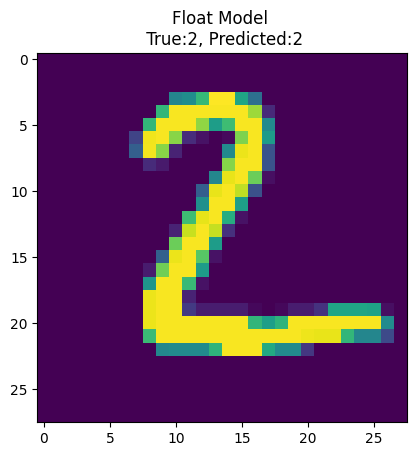

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

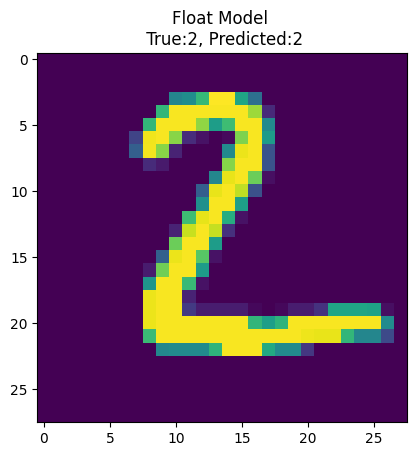

In [ ]:
test_model(tflite_model_quant_file2, test_image_index, model_type="Float")

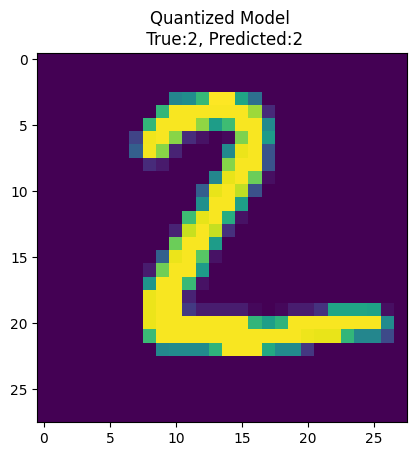

In [ ]:
test_model(tflite_model_quant_file3, test_image_index, model_type="Quantized")

### Evaluate the models on all images

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 96.3500% (Number of test samples=10000)


In [ ]:
evaluate_model(tflite_model_quant_file2, model_type="Float")

Float model accuracy is 96.3100% (Number of test samples=10000)


In [ ]:
evaluate_model(tflite_model_quant_file3, model_type="Quantized")

Quantized model accuracy is 96.3600% (Number of test samples=10000)
